In [397]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.ModifiedMiCRM.RandomSystems

In [398]:
using Base.Threads
using JLD2

In [399]:
using CairoMakie
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# No-space steady state solving

In [400]:
ps = load_object("./params.jld2");
u0 = make_u0_smart(ps; u0=:onlyN)
get_Ns(ps)

(10, 20)

In [401]:
# Steady state
ssp = make_mmicrm_ss_problem(ps, u0)
ssp = remake_guarantee_positive(ssp)
@time sss = solve(ssp, DynamicSS(QNDF());
    abstol=eps(),
    reltol=eps(),
    callback=make_timer_callback(10),
);
maximum(abs, sss.resid)

  2.267073 seconds (3.80 M allocations: 270.271 MiB, 20.70% gc time, 84.19% compilation time)


2.0301992208959463e-14

In [402]:
# Fixed time with evolution
p = make_mmicrm_problem(ps, u0, 100000000000000);
p = remake_guarantee_positive(p)

@time s = solve(p, QNDF();
    callback=CallbackSet(
        make_timer_callback(20),
        PositiveDomain(p.u0; abstol=1e-12)
    )
)

# f = plot_mmicrm_sol(s)
# display(GLMakie.Screen(), f)
# display(f)

maximum(abs, uninplace(mmicrmfunc!)(s.u[end], ps))

 20.002002 seconds (3.08 M allocations: 747.674 MiB, 11.84% gc time)


1.5173370535684302e-10

# Spatial prep + diagram

In [403]:
# nssol = s.u[end];
nssol = sss.u
xx = uninplace(mmicrmfunc!)(nssol, ps)
maxresid = maximum(abs, xx)
@show maxresid;

maxresid = 1.1988757040423928e-14


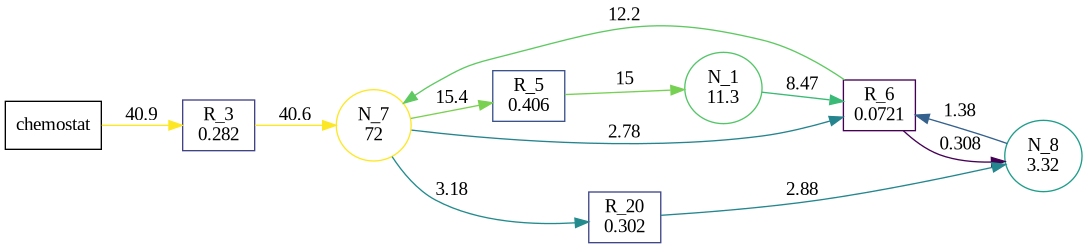

In [404]:
g = diagram_sfss_v3(ps, nssol;
    strain_threshold=1e-10,
    edge_threshold=1e-20,
    # cluster=true,
)

# Linear stability with different diffusion constants

### Base diffusions, resources 1 and strains 1e-8 - stable

In [405]:
ks = LinRange(0., 1000., 10000)

Ds = vcat(
    fill(1e-8, get_Ns(ps)[1]),
    fill(1, get_Ns(ps)[2])
)

lamfunc = linstab_make_k_func(ps, Ds, nssol)
lambdas = lamfunc.(ks);

maximum(x->maximum(real, x), lambdas)

-0.0002977087022411577

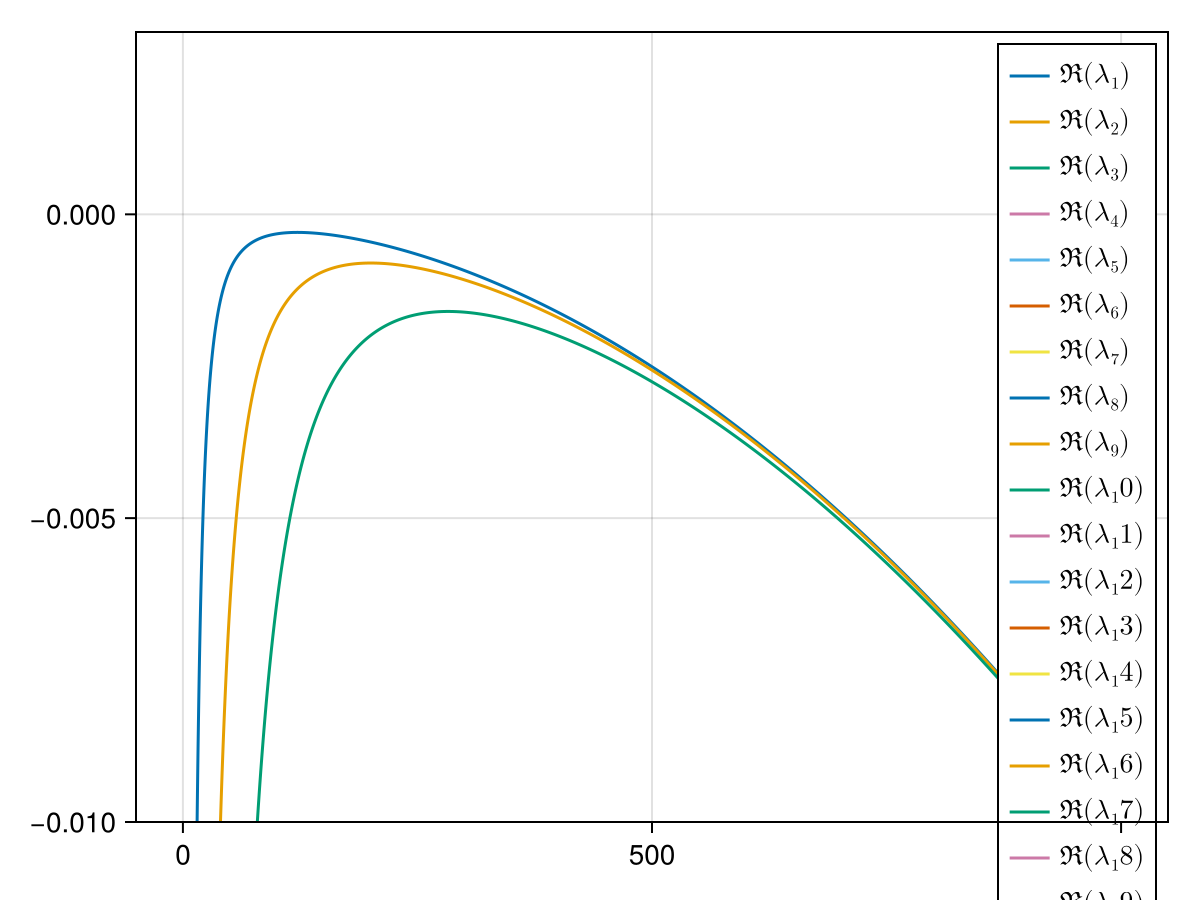

In [406]:
faa = plot_linstab_lambdas(ks, lambdas;
    imthreshold=Inf
)
# display(GLMakie.Screen(), faa.figure)
ylims!(faa.axis, -0.01, 0.003)
# xlims!(faa.axis, 0., 1000)
faa

### Reducing byproduct diffusions - unstable

In [407]:
ks = LinRange(0., 1000., 10000)

Ds = vcat(
    fill(1e-8, get_Ns(ps)[1]),
    fill(1, get_Ns(ps)[2])
)

Ns = get_Ns(ps)[1]
# Ds[Ns+3] = 100
Ds[Ns+5] = 1e-3
Ds[Ns+6] = 1e-3
Ds[Ns+20] = 1e-3

lamfunc = linstab_make_k_func(ps, Ds, nssol)
lambdas = lamfunc.(ks);

maximum(x->maximum(real, x), lambdas)

0.0010819294251180958

[ Info: Unstable, mrl is 0.00108193


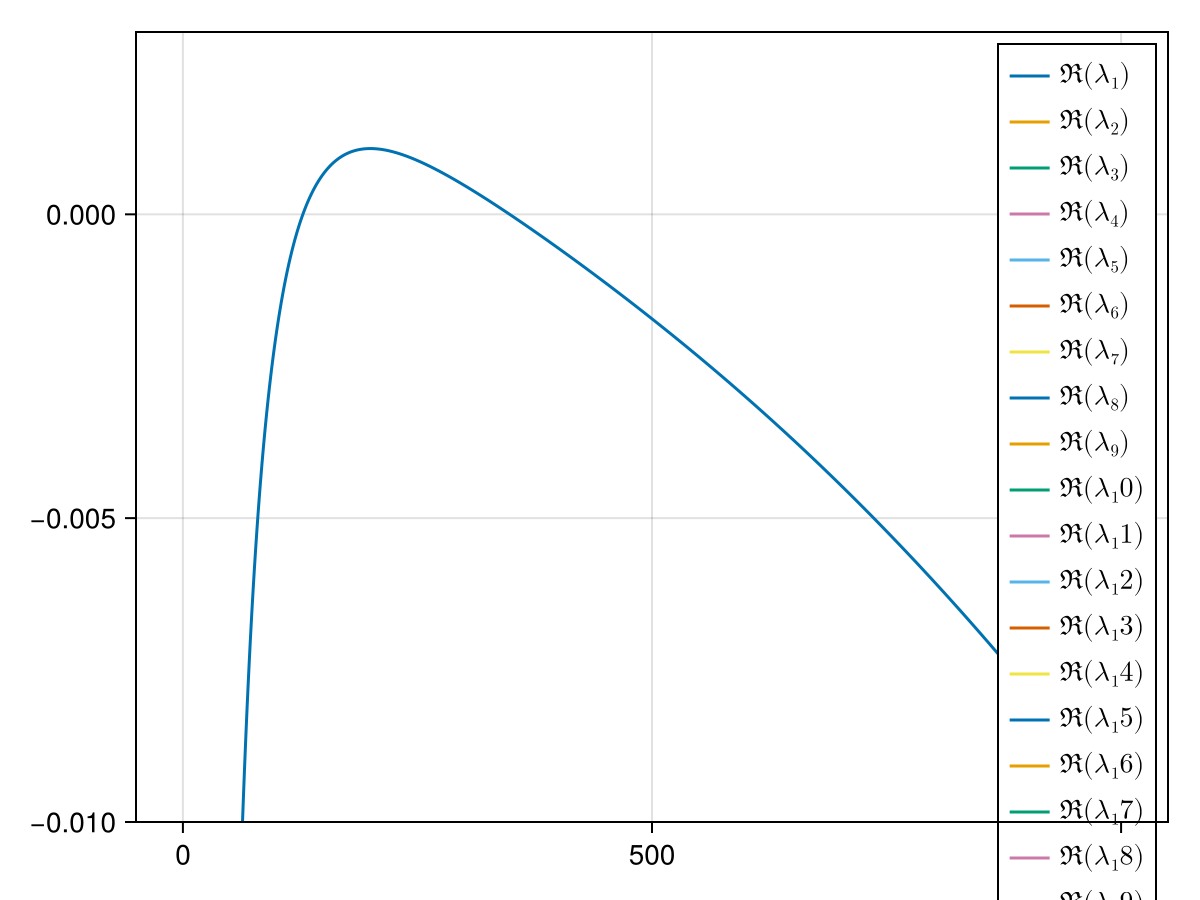

In [408]:
faa = plot_linstab_lambdas(ks, lambdas;
    imthreshold=Inf
)
# display(GLMakie.Screen(), faa.figure)
ylims!(faa.axis, -0.01, 0.003)
# xlims!(faa.axis, 0., 1000)
faa

### Further reducing strain diffusions leads to more attainable instabilities

In [409]:
ks = LinRange(0., 5000., 10000)

Ds = vcat(
    fill(1e-10, get_Ns(ps)[1]),
    fill(1, get_Ns(ps)[2])
)

Ns = get_Ns(ps)[1]
# Ds[Ns+3] = 100
Ds[Ns+5] = 1e-1
Ds[Ns+6] = 1e-1
Ds[Ns+20] = 5e-1

lamfunc = linstab_make_k_func(ps, Ds, nssol)
lambdas = lamfunc.(ks);

maximum(x->maximum(real, x), lambdas)

3.0983425069007084e-5

[ Info: Unstable, mrl is 3.09834e-05


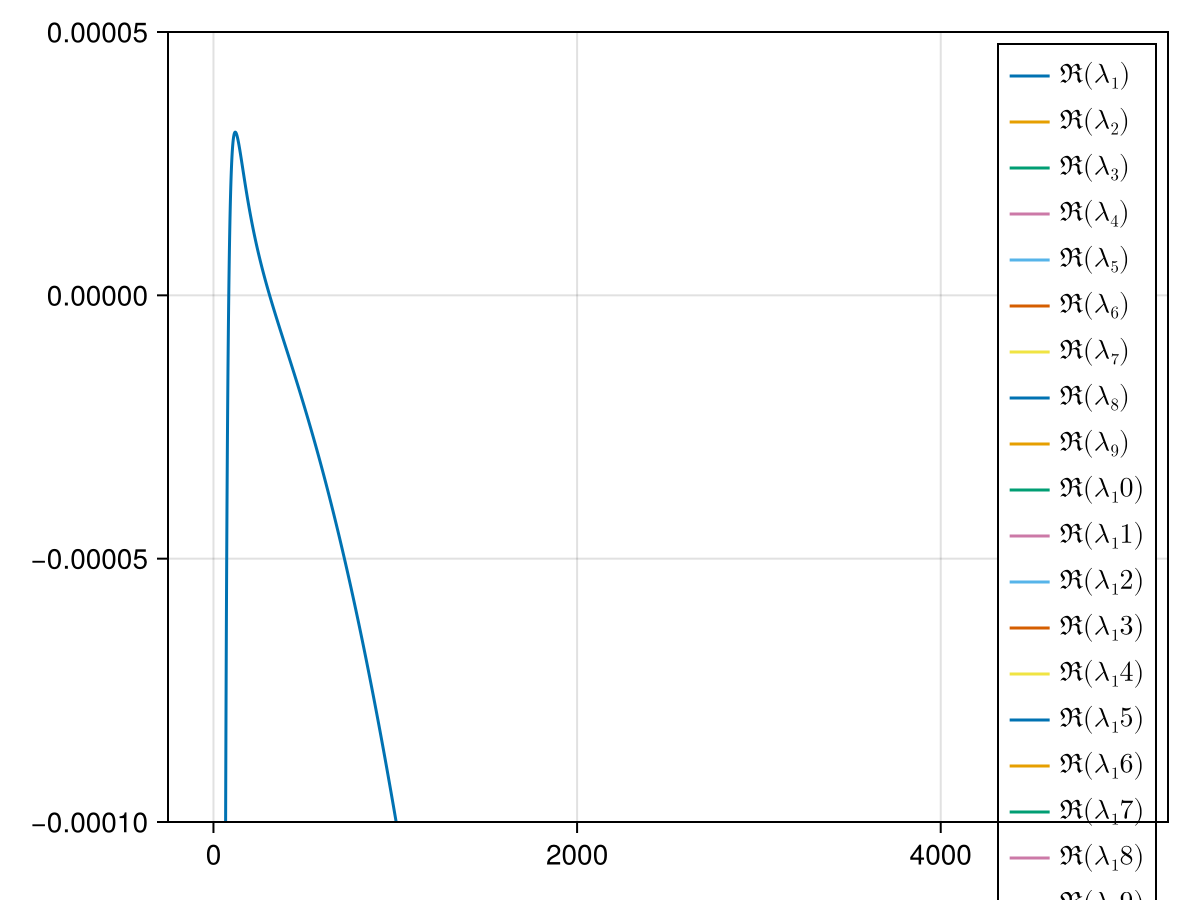

In [410]:
faa = plot_linstab_lambdas(ks, lambdas;
    imthreshold=Inf
)
# display(GLMakie.Screen(), faa.figure)
ylims!(faa.axis, -0.0001, 0.00005)
# xlims!(faa.axis, 0., 1000)
faa

### Reducing some byproduct diffusions - more unstable and leads to a frustrated system in the long term (PDEs)

In [411]:
ks = LinRange(0., 1000., 10000)

Ds = vcat(
    fill(1e-8, get_Ns(ps)[1]),
    fill(1, get_Ns(ps)[2])
)

Ns = get_Ns(ps)[1]
Ds[Ns+5] = 1e-3
Ds[Ns+6] = 1e-3
Ds[Ns+20] = 1e0

lamfunc = linstab_make_k_func(ps, Ds, nssol)
lambdas = lamfunc.(ks);

maximum(x->maximum(real, x), lambdas)

0.0024211917607283263

[ Info: Unstable, mrl is 0.00242119


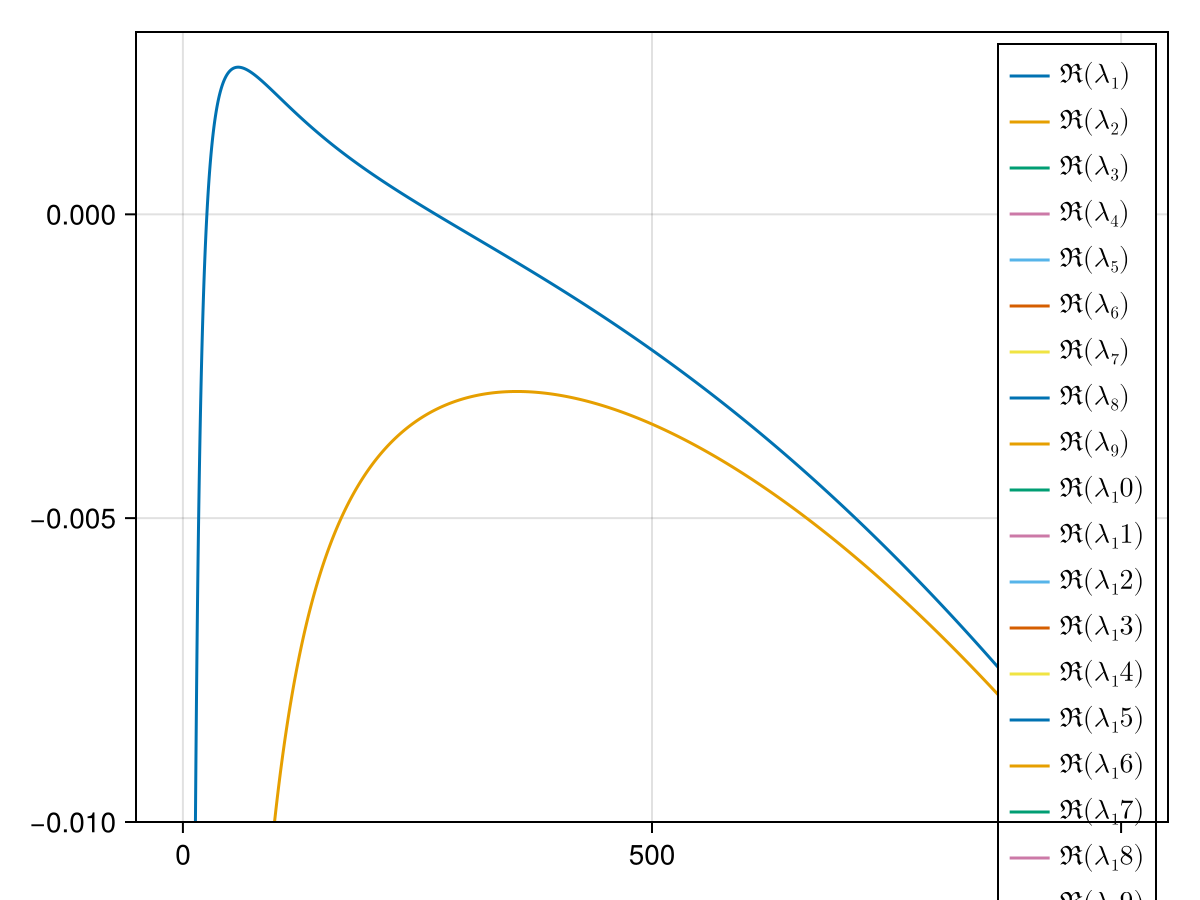

In [412]:
faa = plot_linstab_lambdas(ks, lambdas;
    imthreshold=Inf
)
# display(GLMakie.Screen(), faa.figure)
ylims!(faa.axis, -0.01, 0.003)
# xlims!(faa.axis, 0., 1000)
faa

### More testing

In [413]:
ks = LinRange(0., 1000., 10000)

Ds = vcat(
    fill(1e-8, get_Ns(ps)[1]),
    fill(1, get_Ns(ps)[2])
)

Ns = get_Ns(ps)[1]
Ds[Ns+5] = 1e-3
Ds[Ns+6] = 1e-3
Ds[Ns+20] = 1e0

lamfunc = linstab_make_k_func(ps, Ds, nssol)
lambdas = lamfunc.(ks);

maximum(x->maximum(real, x), lambdas)

0.0024211917607283263

[ Info: Unstable, mrl is 0.00242119


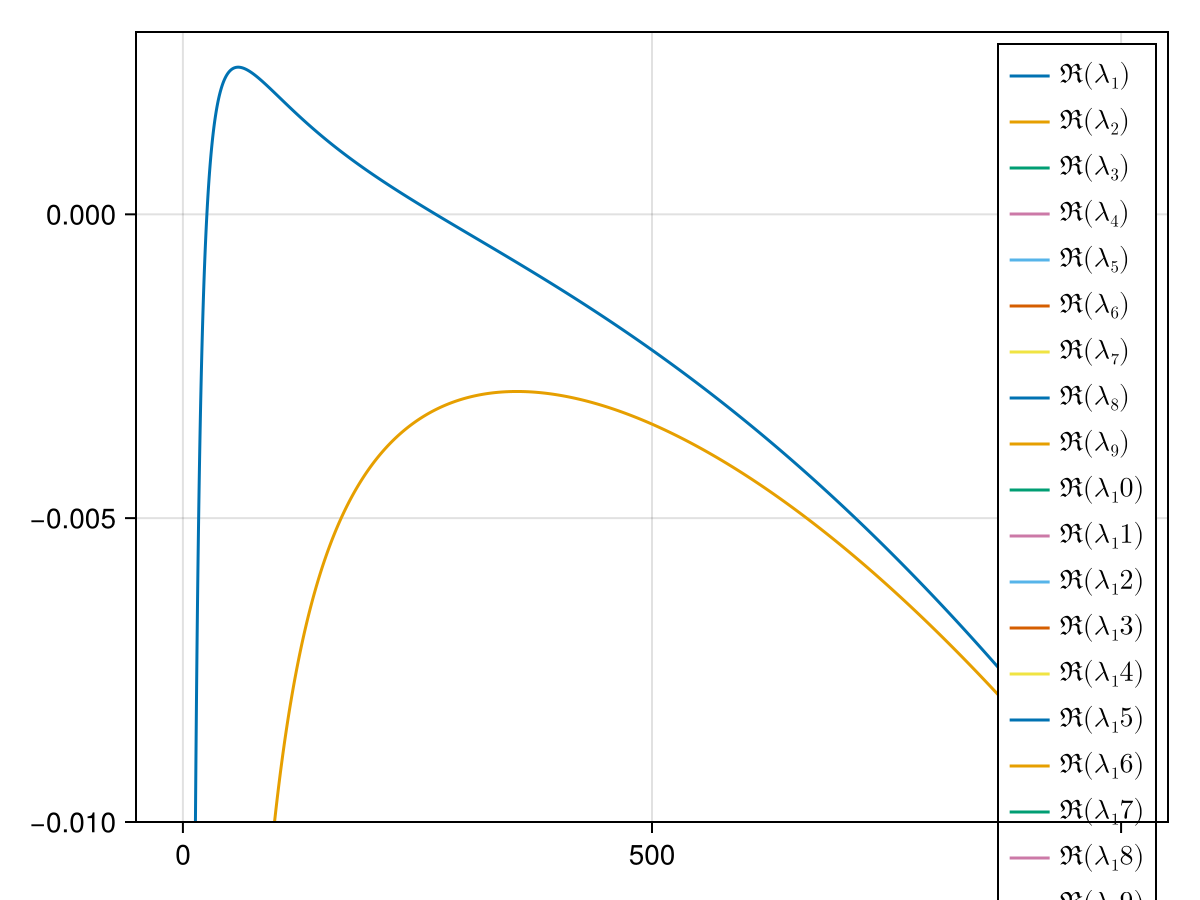

In [414]:
faa = plot_linstab_lambdas(ks, lambdas;
    imthreshold=Inf
)
# display(GLMakie.Screen(), faa.figure)
ylims!(faa.axis, -0.01, 0.003)
# xlims!(faa.axis, 0., 1000)
faa

# Running PDEs

In [374]:
unique(Ds)

4-element Vector{Float64}:
 1.0e-10
 1.0
 0.1
 0.5

In [393]:
ssize = (5000,)
dx = 0.00005

baseu0 = nssol
# baseu0 = make_u0_smart(ps; u0=:onlyN)
su0 = expand_u0_to_size(ssize, baseu0)
su0 = perturb_u0_uniform_prop(get_Ns(ps)..., su0, 0.1, 0.1)

spaceps = change_bsmmicrmparams(ps;
    space=make_cartesianspace_smart(1;
        dx,
        bcs=Periodic()
    ),
    Ds=Ds,
    usenthreads=nthreads()
)
@show spaceps.usenthreads spaceps.mmicrm_params.usenthreads

sp = make_smmicrm_problem(spaceps, su0, 1000000000000000);

spaceps.usenthreads = 18
spaceps.mmicrm_params.usenthreads = nothing


In [394]:
@time sps = solve(sp, QNDF();
    callback=make_timer_callback(60*5),
);
print_spatial_solution_stats(sps)

 89.174901 seconds (2.83 M allocations: 46.667 GiB, 7.81% gc time)
Success
nf is 967
solution has 155 saved states
max resid is 1.71393e-07


┌ Warning: reaching negative values, minimum is -1.486e-16
└ @ SSMCMain.ModifiedMiCRM ~/UCLOneDrive/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


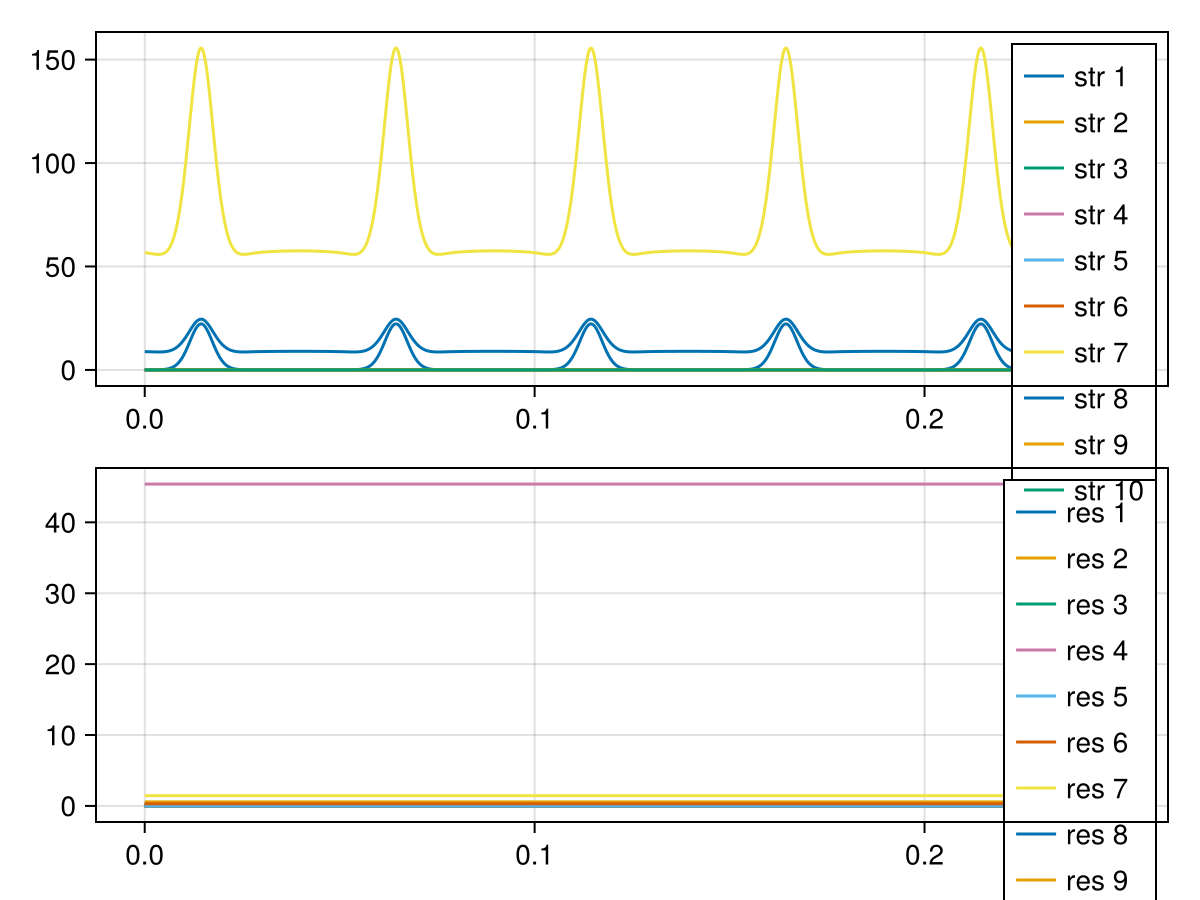

In [395]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

In [396]:
f = plot_1dsmmicrm_sol_interactive(sps)
display(GLMakie.Screen(), f)

GLMakie.Screen(...)

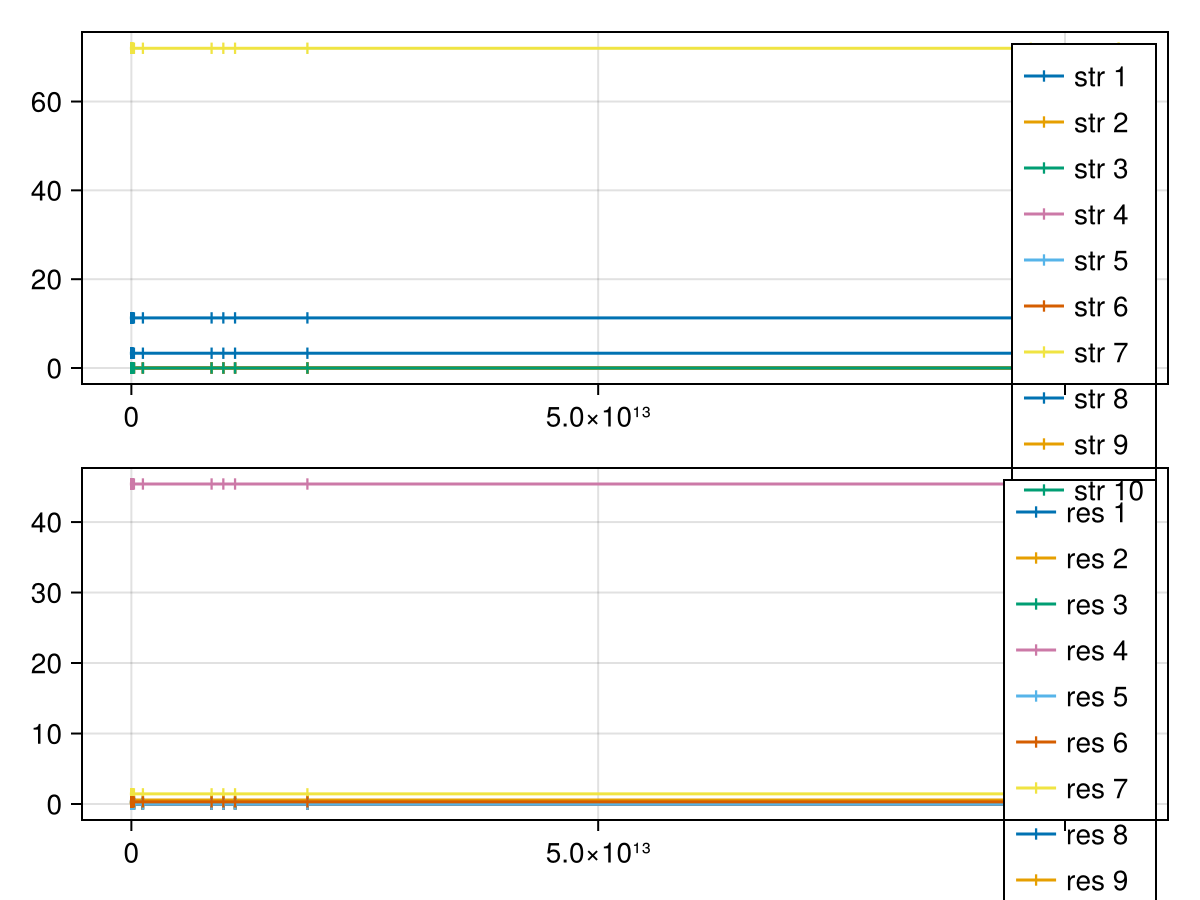

In [383]:
f = plot_smmicrm_sol_avgs(sps)
# display(GLMakie.Screen(), f)
f

In [304]:
save_object("temp.jld2", sps)

# Extras

In [189]:
GC.gc()
empty!(Out)
GC.gc()